# 4M-21: An Any-to-Any Vision Model for Tens of Tasks and Modalities

Roman Bachmann\*, Oguzhan Fatih Kar\*, David Mizrahi\*, Ali Garjani, Mingfei Gao, David Griffiths, Jiaming Hu, Afshin Dehghan, Amir Zamir

(\* Equal contribution, random order)

[`Website`](https://4m.epfl.ch) | [`Paper`](https://arxiv.org/abs/2406.09406) | [`GitHub`](https://github.com/apple/ml-4m)

We adopt the 4M framework to scale a vision model to tens of tasks and modalities. The resulting model, named 4M-21, has significantly expanded out-of-the-box capabilities, and yields stronger results on downstream transfer tasks. 

The diverse set of modalities we incorporated unlock new potential for multimodal interaction, such as retrieval from and across multiple modalities, or highly steerable generation of any of the training modalities, all in a single model.

This notebook contains examples for 4M-21 inference, specifically performing any-to-any retrieval.

Note: We set the retrieval set size as 10k for this notebook for convenience with experimenting. Increasing the retrieval set further improves the performance.

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [ ]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
from matplotlib import gridspec

try:
    import faiss
except:
    print('Please install faiss via pip install faiss-gpu to perform retrieval.')


from fourm.models.fm import FM
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality, custom_text
from fourm.data.modality_transforms import RGBTransform
from fourm.data.modality_info import MODALITY_INFO
from fourm.data.modality_transforms import MetadataTransform
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square, decode_tok_depth, decode_tok_semseg



# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

### Load tokenizers

To encode modalities into discrete tokens, and in turn decode the tokens that 4M predicts, we use modality-specific tokenizers. We can easily load them from [Hugging Face hub](https://huggingface.co/EPFL-VILAB) with the below lines.

The tokenizer checkpoint names are formated as: `f'4M_tokenizers_{modality}_{vocab_size}_{min_res}-{max–res}'`.
All tokenizers here are trained to work on resolutions between 224 and 448, in steps of 32.

In [3]:
text_tok = Tokenizer.from_file('./fourm/utils/tokenizer/trained/text_tokenizer_4m_wordpiece_30k.json')

toks = {
    'tok_depth': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_depth_8k_224-448').eval().to(device),
    'tok_semseg': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').eval().to(device),
    'tok_dinov2_global': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_DINOv2-B14-global_8k_16_224').eval().to(device),
    # 'tok_imagebind_global': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_ImageBind-H14-global_8k_16_224').eval().to(device),
}

### Load a 4M-21 model

Let's load a 4M-21 XL model that was trained on 21 modalities, including RGB, depth, surface normals, semantic segmentation, SAM instances, Canny & SAM edges, 3D human poses, CLIP-B/16 features, DINOv2-B/14 features, ImageBind-H/14 features, captions, metadata, color palette and bounding boxes. It can take any combination of those modalities as input, and can predict all of them. We wrap the model in a `GenerationSampler` which provides inference utilities.

Please see [official repo's](https://github.com/apple/ml-4m) `README.md` for all available 4M and tokenizer models.

In [4]:
fm = FM.from_pretrained('EPFL-VILAB/4M-21_XL').eval().to(device)
sampler = GenerationSampler(fm)

### RGB → DINOv2 (or ImageBind) global embedding

Given an RGB input, predict DINOv2 or ImageBind. Inference/generation is done by providing a _generation schedule_ to the `GenerationSampler`. 
A _generation schedule_ specifies the order of modalities to generate, and for each it contains the generation parameters like number of steps or temperature.
We provide a convenience function `build_chained_generation_schedules` that allows for building arbitrary chained generation schedules.
We call it chained generation, since every newly generated output is looped back into the input and serves as conditioning for subsequently generated modalities.
This enables generating multiple modalities that are all consistent with each other, which is mostly important when the conditioning is underspecified.
Please see the generation notebook and the paper for more details on chained generation.

The `build_chained_generation_schedules` function takes several inputs. 
Please see the generation README in `README_GENERATION.md` for detailed information on each of them, and tips on how to set them.
In the following, we give an RGB image as input (pixels not tokens), and predict DINOv2 (or ImageBind) global embeddings from it. Note that while this demo uses an RGB image as input to predict the global embeddings, any other subset of modalities can also be used.

In [5]:
cond_domains = ['rgb@224']
target_domains = ['tok_dinov2_global'] # or 'tok_imagebind_global'
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = ['linear']
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  217k  100  217k    0     0  1925k      0 --:--:-- --:--:-- --:--:-- 1908k


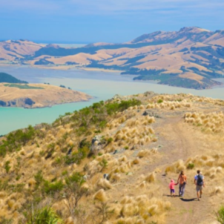

In [6]:
# Download image from the specified URL and preprocess it
image_url = 'https://storage.googleapis.com/four_m_site/images/demo_rgb.png'
!curl $image_url --output input.jpg

rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)
img_pil = rgb_transform.load('./input.jpg')
img_pil = rgb_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((224,224))
img = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
img_pil

In [7]:
# Download retrieval data for depth and semantic segmentation (3.8G)
retrieval_data_url = 'https://datasets.epfl.ch/vilab/retrieval_data_4m/retrieval_data_4m.tar.gz'
!curl $retrieval_data_url --output retrieval_data_4m.tar.gz
!tar -xvf retrieval_data_4m.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3003M  100 3003M    0     0  18.3M      0  0:02:43  0:02:43 --:--:-- 19.3M
retrieval_data/
retrieval_data/retrieval_set_depth_10k.pth
retrieval_data/retrieval_set_semseg_10k.pth
retrieval_data/depth_tokens_10k.pth
retrieval_data/semseg_tokens_10k.pth


In [8]:
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

Now we are ready to perform the generation. The `GenerationSampler` has a `.generate` function that performs the chained generation on a given sample dictionary, following the previously specified generation schedule.
It outputs a dictionary that is formatted in the same manner as the sample dictionary, but contains also the predicted tokens. You can change the seed to get different outputs, or set it to None to randomly sample.

4M / the sampler outputs discrete tokens, and we still need to decode them to images, feature maps, text, etc using the modality-specific tokenizers. 
For that, we provide the `decode_dict` function that takes as input the sample dictionary and the tokenizers, and returns plottable representations of each modality.
Some modalities like RGB, depth and normals use a diffusion model as the tokenizer decoder. You can specify the number of DDIM steps for decoding with `decoding_steps`.

In [9]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00,  1.49it/s]


Load depth retrieval set and tokens.  

In [10]:
depth_retrieval_set_embeddings = torch.load('./retrieval_data/retrieval_set_depth_10k.pth')
depth_retrieval_set_tokens = torch.load('./retrieval_data/depth_tokens_10k.pth')

Given the global embedding predicted for the query and retrieval set, now we can perform retrieval by comparing their cosine distances.

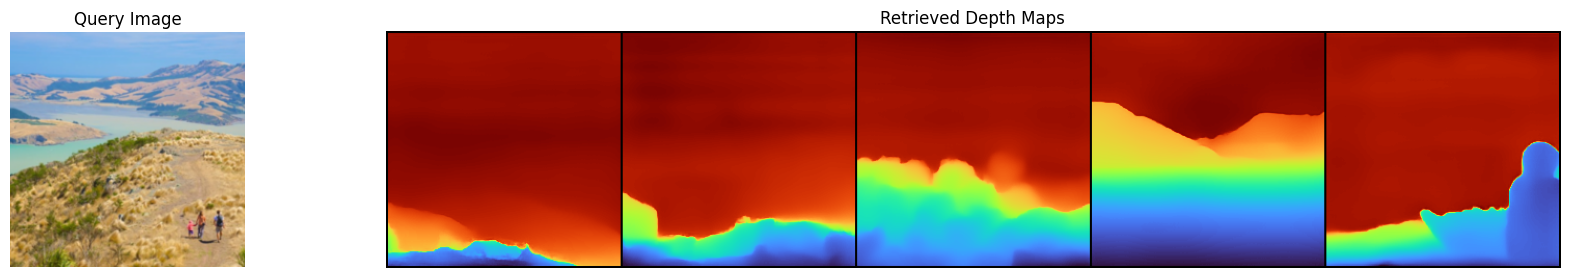

In [11]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(depth_retrieval_set_embeddings.size(1))
index.add(depth_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(dec_dict[cond_domains[0]], cmap='gray')
ax0.set_title("Query Image")
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = depth_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_depth(batched_sample, toks, 'tok_depth@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Depth Maps")
ax1.axis('off')
plt.show()


Let's do the same to retrieve semantic segmentation maps.
First load the retrieval set embeddings and tokens.

In [12]:
semseg_retrieval_set_embeddings = torch.load('./retrieval_data/retrieval_set_semseg_10k.pth')
semseg_retrieval_set_tokens = torch.load('./retrieval_data/semseg_tokens_10k.pth')

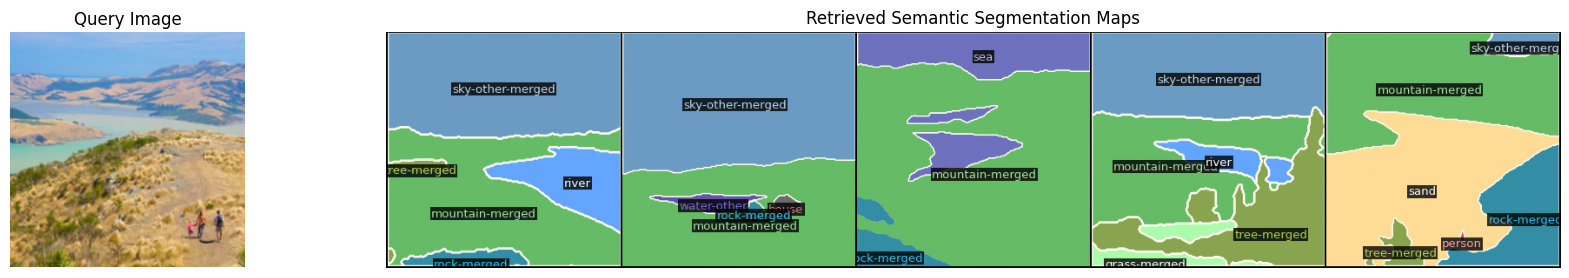

In [13]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(dec_dict[cond_domains[0]], cmap='gray')
ax0.set_title("Query Image")
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()


### Caption + Metadata → DINOv2 (or ImageBind) global embedding

Alternatively, we can use multimodal input (e.g. a caption and metadata) to perform retrieval.

In [14]:
cond_domains = ['caption', 'metadata']
target_domains = ['tok_dinov2_global'] # or 'tok_imagebind_global'
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

In [15]:
caption = 'hiking in the mountains on a sunny day' 
metadata_transform = MetadataTransform(shuffle=False, random_trunc=False, return_chunks=False)
metadata_dict = {
    'semantic_diversity': 2,
}
metadata_str = metadata_transform.metadata_to_string(metadata_dict) + ' [S_1]'


batched_sample = {}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)

batched_sample = custom_text(batched_sample, input_text=caption, text_tokenizer=text_tok, eos_token='[EOS]', key='caption', device=device, target_max_len=256, start_token='[S_1]')
batched_sample = custom_text(batched_sample, input_text=metadata_str, text_tokenizer=text_tok, eos_token='[EOS]', key='metadata', device=device)


In [16]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 22.64it/s]


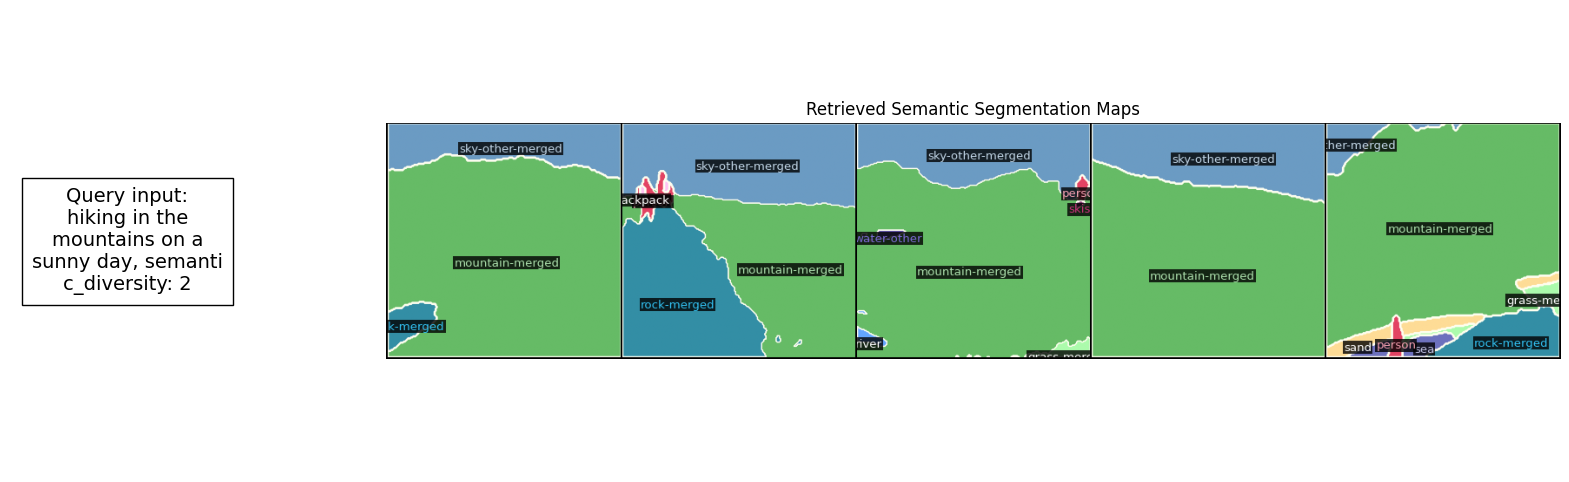

In [17]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
metadata_text = ',\n'.join([f'{k}: {v:.2f}' if isinstance(v, float) else f'{k}: {v}' for k, v in metadata_dict.items()])
plot_text_in_square(ax0, "Query input: " + caption + ", " + metadata_text, wrap_width=18, fontsize=14)
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()


Let's increase the semantic diversity of the scene.

In [18]:

caption = 'hiking in the mountains on a sunny day' 
metadata_transform = MetadataTransform(shuffle=False, random_trunc=False, return_chunks=False)
metadata_dict = {
    'semantic_diversity': 20,
}
metadata_str = metadata_transform.metadata_to_string(metadata_dict) + ' [S_1]'


batched_sample = {}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)

batched_sample = custom_text(batched_sample, input_text=caption, text_tokenizer=text_tok, eos_token='[EOS]', key='caption', device=device, target_max_len=256, start_token='[S_1]')
batched_sample = custom_text(batched_sample, input_text=metadata_str, text_tokenizer=text_tok, eos_token='[EOS]', key='metadata', device=device)


In [19]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 27.68it/s]


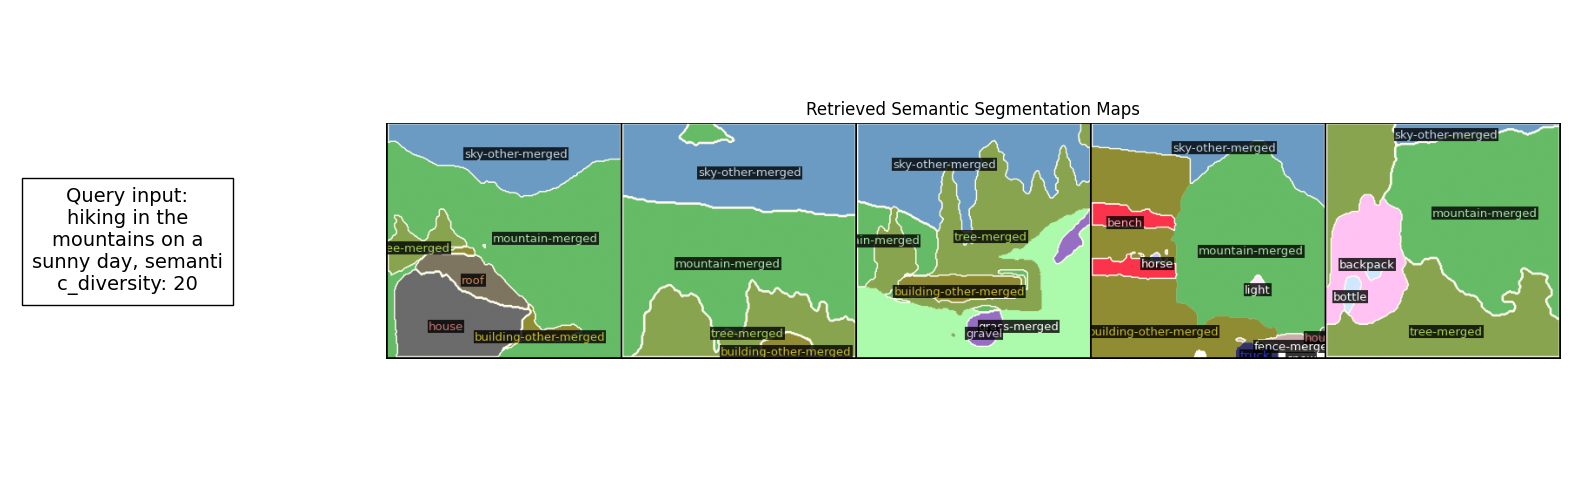

In [20]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
metadata_text = ',\n'.join([f'{k}: {v:.2f}' if isinstance(v, float) else f'{k}: {v}' for k, v in metadata_dict.items()])
plot_text_in_square(ax0, "Query input: " + caption + ", " + metadata_text, wrap_width=18, fontsize=14)
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()
